![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)

# Deep Learning in Earth Observation: Taizhou Change Detection

### Lichao Mou, German Aerospace Center; Xiaoxiang Zhu, German Aerospace Center & Technical University Munich 

<img src="NotebookAddons/dlr-logo-png-transparent.png" width="170" align="right" border="2"/> <font size="3"> 
    
This notebook introduces you to the basic concepts of Deep Learning in Earth Observation. Specifically, it uses Convolutional Recurrent Neural Networks (CRNNs) to perform a multi-temporal change detection on multispectral data collected over Taizhou, China. The images are both 400 × 400 pixels in size and show significant changes mainly related to city expansion, soil change, and varying water areas.

This notebook will introduce the following data analysis concepts:

- How to set up a convolutional recurrent deep network within the Python-based *keras/tensorflow* environment
- How to use CRNNs to perform change detection on multi-temporal remote sensing data 

**Important Note about JupyterHub**

Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/machine_learning':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "machine_learning" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "machine_learning" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "machine_learning" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

--- 
## 0. Importing Relevant Python Packages

Our first step is to **import the necessary python libraries into your Jupyter Notebook.**

In [3]:
%%capture
from pathlib import Path

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Nadam
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers import Conv2D, Reshape, Activation, Concatenate, GRU, Dense, LSTM, SimpleRNN

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()

2022-02-08 22:08:42.287842: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 22:08:42.287891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---
## 1. Create a working directory for the analysis and change into it:

In [4]:
base_path = Path("/home/jovyan/notebooks/SAR_Training/English/Master/data_CRNN_change_detection")

if not base_path.exists():
    base_path.mkdir()

---
## 2. Data Preparation

**load T1 and T2 images, training map, and test map. Save the images (T1.png and T2.png):**

In [5]:
# Retrieve DL-data from AWS

work_dir = Path.cwd()/'DL-data'

if not work_dir.exists():
    work_dir.mkdir() 
    
dl_data_path = work_dir/'Taizhou_3x3'
!aws --region=us-west-2 --no-sign-request s3 cp s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/ {dl_data_path} --recursive

download: s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/TaizhouTraMapMulti.mat to DL-data/Taizhou_3x3/TaizhouTraMapMulti.mat
download: s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/TaizhouTestMapMulti.mat to DL-data/Taizhou_3x3/TaizhouTestMapMulti.mat
download: s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/TaizhouTraMapBinary.mat to DL-data/Taizhou_3x3/TaizhouTraMapBinary.mat
download: s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/TaizhouTm2000_norm.mat to DL-data/Taizhou_3x3/TaizhouTm2000_norm.mat
download: s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/TaizhouTm2003_norm.mat to DL-data/Taizhou_3x3/TaizhouTm2003_norm.mat
download: s3://asf-jupyter-data-west/DL-data/Taizhou_3x3/TaizhouTestMapBinary.mat to DL-data/Taizhou_3x3/TaizhouTestMapBinary.mat


########## load data... ##########
the shape of T1 image is: (402, 402, 6)
the shape of T2 image is: (402, 402, 6)


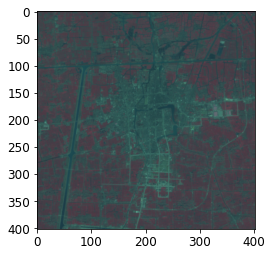

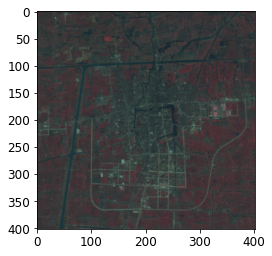

In [6]:
patch_size = 3
num_bands = 6
print('########## load data... ##########')
data = sio.loadmat(str(dl_data_path/'TaizhouTm2000_norm.mat'))
imgT1 = np.float32(data['imgT1'])
data = sio.loadmat(str(dl_data_path/'TaizhouTm2003_norm.mat'))
imgT2 = np.float32(data['imgT2'])

data = sio.loadmat(str(dl_data_path/'TaizhouTraMapBinary.mat'))
tra_map = np.uint8(data['tra_map_binary'])
data = sio.loadmat(str(dl_data_path/'TaizhouTestMapBinary.mat'))
test_map = np.uint8(data['test_map_binary'])

print('the shape of T1 image is: {}'.format(imgT1.shape))
print('the shape of T2 image is: {}'.format(imgT2.shape))

plt.imshow(imgT1[:, :, [3, 2, 1]])
plt.savefig(f"{base_path}/T1.png", dpi=300)
plt.show()

plt.imshow(imgT2[:, :, [3, 2, 1]])
plt.savefig(f"{base_path}/T2.png", dpi=300)
plt.show()

[rows, cols] = np.nonzero(tra_map)
num_samples = len(rows)
rows = np.reshape(rows, (num_samples, 1))
cols = np.reshape(cols, (num_samples, 1))
temp = np.concatenate((rows, cols), axis=1)
np.random.shuffle(temp)
rows = temp[:, 0].reshape((num_samples,))
cols = temp[:, 1].reshape((num_samples,))

Create 3x3 patches as training samples according to the training map

**Create numpy arrays temporarily filled with zeros to hold our 3x3 patches:**

In [7]:
x_tra_t1 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
x_tra_t2 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))

y_tra = np.uint8(np.zeros([num_samples, ])) # ground truths for training samples

**Populate the zero-filled arrays with appropriate values:**

In [8]:
for i in range(num_samples):
    patch = imgT1[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_tra_t1[i, :, :, :] = patch
    patch = imgT2[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_tra_t2[i, :, :, :] = patch
    y_tra[i] = tra_map[rows[i], cols[i]]-1

[rows, cols] = np.nonzero(test_map)
num_samples = len(rows)
rows = np.reshape(rows, (num_samples, 1))
cols = np.reshape(cols, (num_samples, 1))
temp = np.concatenate((rows, cols), axis=1)
np.random.shuffle(temp)
rows = temp[:, 0].reshape((num_samples,))
cols = temp[:, 1].reshape((num_samples,))

**Sample 3x3 patches as test samples according to the test map:**

In [9]:
# test samples from T1 image
x_test_t1 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
# test samples from T2 image
x_test_t2 = np.float32(
    np.zeros([num_samples, patch_size, patch_size, num_bands]))
# ground truths for test samples
y_test = np.uint8(np.zeros([num_samples, ]))  
for i in range(num_samples):
    patch = imgT1[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_test_t1[i, :, :, :] = patch
    patch = imgT2[rows[i]-int((patch_size-1)/2): rows[i]+int((patch_size-1)/2)+1,
                  cols[i]-int((patch_size-1)/2): cols[i]+int((patch_size-1)/2)+1, :]
    x_test_t2[i, :, :, :] = patch
    y_test[i] = test_map[rows[i], cols[i]]-1

print('the shape of input tensors on training set is: {}'.format(x_tra_t1.shape))
print('the shape of target tensor on training set is: {}'.format(y_tra.shape))
print('the shape of input tensors on training set is: {}'.format(x_test_t1.shape))
print('the shape of target tensor on training set is: {}'.format(y_test.shape))

the shape of input tensors on training set is: (1000, 3, 3, 6)
the shape of target tensor on training set is: (1000,)
the shape of input tensors on training set is: (21016, 3, 3, 6)
the shape of target tensor on training set is: (21016,)


---
## 3. Building up the recurrent convolutional network 

**Write a function to build the network:**

In [10]:
def build_network():
    # the T1 branch of the convolutional sub-network
    input1 = Input(shape=(3, 3, 6))
    x1 = Conv2D(filters=32, kernel_size=3, strides=1, padding='valid')(input1)
    x1 = Activation('relu')(x1)
    x1 = Reshape(target_shape=(1, 32))(x1)

    # the T2 branch of the convolutional sub-network
    input2 = Input(shape=(3, 3, 6))
    x2 = Conv2D(filters=32, kernel_size=3, strides=1, padding='valid')(input2)
    x2 = Activation('relu')(x2)
    x2 = Reshape(target_shape=(1, 32))(x2)

    # the recurrent sub-network
    x = Concatenate(axis=1)([x1, x2])
    #x = SimpleRNN(units = 128)(x)
    x = LSTM(units=128)(x)
    #x = GRU(units = 128)(x)
    x = Dense(units=32, activation='relu')(x)
    y = Dense(units=1, activation='sigmoid')(x)

    net = Model(inputs=[input1, input2], outputs=y)

    net.summary()

    return net


---
## 4. Network training

**Build the network:**

In [11]:
print('########## train the network... ##########')
batch_size = 32
nb_epoch = 200
net = build_network()

########## train the network... ##########


2022-02-08 22:08:53.488477: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-08 22:08:53.488700: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-08 22:08:53.488713: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 22:08:53.488735: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-rkawahara): /proc/driver/nvidia/version does not exist
2022-02-08 22:08:53.488929: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with t

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 3, 6)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 3, 6)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1, 1, 32)     1760        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 1, 32)     1760        input_2[0][0]                    
______________________________________________________________________________________________

**Train the network:**

Epoch 1/200


2022-02-08 22:08:53.831915: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-08 22:08:53.832535: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199970000 Hz


29/29 [==============================] - 3s 34ms/step - loss: 0.6937 - accuracy: 0.4915 - val_loss: 0.6934 - val_accuracy: 0.4700
Epoch 2/200
29/29 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5268 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/200
29/29 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5580 - val_loss: 0.6921 - val_accuracy: 0.6800
Epoch 4/200
29/29 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.7330 - val_loss: 0.6917 - val_accuracy: 0.8400
Epoch 5/200
29/29 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.8348 - val_loss: 0.6912 - val_accuracy: 0.8200
Epoch 6/200
29/29 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.7515 - val_loss: 0.6907 - val_accuracy: 0.6100
Epoch 7/200
29/29 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5362 - val_loss: 0.6901 - val_accuracy: 0.5300
Epoch 8/200
29/29 [=====

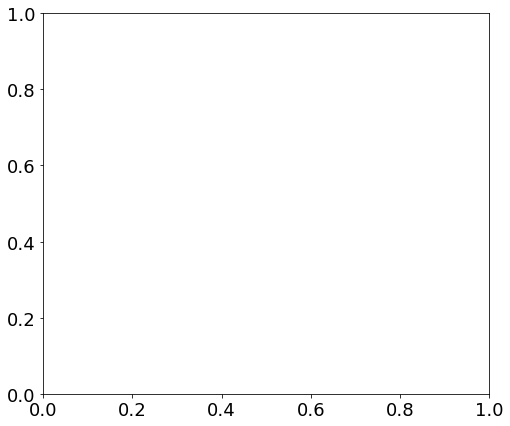

In [12]:
nadam = Nadam(lr=0.00002)
net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
net_info = net.fit([x_tra_t1, x_tra_t2], y_tra,
                   batch_size=batch_size, validation_split=0.1, epochs=nb_epoch)

loss = net_info.history['loss']
loss_val = net_info.history['val_loss']
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)

**Plot and save the results (loss.png):**

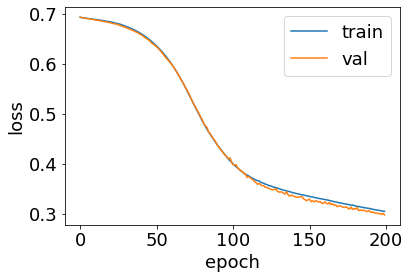

In [13]:
plt.plot(loss)
plt.plot(loss_val)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig(f"{base_path}/loss.png", bbox_inches='tight', dpi=200)
plt.show()

---
## 5. Test

**Run the network on the test dataset. Save the change map probability and the change map binary (change_map_probability.png and change_map_binary.png):**

########## test... ##########
657/657 [==============================] - 1s 2ms/step - loss: 0.2367 - accuracy: 0.9670
0.9669775366783142
########## running on the whole image... ##########
sampling patches...
sampling done.


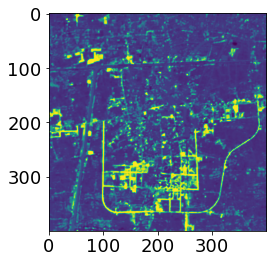

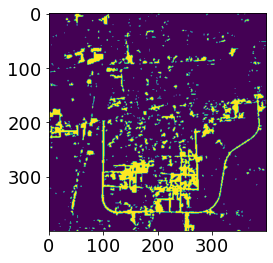

In [14]:
print('########## test... ##########')
# testing on test set
score = net.evaluate([x_test_t1, x_test_t2], y_test)
print(score[1])

print('########## running on the whole image... ##########')
cnt = 0
x_t1 = np.float32(np.zeros([400*400, patch_size, patch_size, num_bands]))
x_t2 = np.float32(np.zeros([400*400, patch_size, patch_size, num_bands]))
print('sampling patches...')
for i in range(1, imgT1.shape[0]-1, 1):
    for j in range(1, imgT1.shape[1]-1, 1):
        patch = imgT1[i-int((patch_size-1)/2): i+int((patch_size-1)/2)+1,
                      j-int((patch_size-1)/2): j+int((patch_size-1)/2)+1, :]
        x_t1[cnt, :, :, :] = patch
        patch = imgT2[i-int((patch_size-1)/2): i+int((patch_size-1)/2)+1,
                      j-int((patch_size-1)/2): j+int((patch_size-1)/2)+1, :]
        x_t2[cnt, :, :, :] = patch
        cnt = cnt + 1
print('sampling done.')
pred = net.predict([x_t1, x_t2])
change_map_prob = np.reshape(pred, (400, 400))
plt.imshow(change_map_prob)
plt.savefig(f"{base_path}/change_map_probability.png", dpi=200)
plt.show()

change_map_binary = np.where(change_map_prob < 0.5, 0, 1)
plt.imshow(change_map_binary)
plt.savefig(f"{base_path}/change_map_binary.png", dpi=200)
plt.show()

*CRNN_change_detection.ipynb - Version 1.3.2 - November 2021*

*Version Changes:*

- asf_notebook -> opensarlab_lib
- html -> markdown
- url_widget